In [83]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Dataset

We import the dataset from Hastie & Tibshirani book. 
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [25]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [63]:
class AdaBoost:
    def __init__(self, weakModel, T):
        self.T = T
        self.weakModel = weakModel
        self.alphas = []
        self.classifiers = []
        self.wl_errors = []
        self.ens_errors = []

    def trainWeakModel(self, X, y, w):
        result = deepcopy(self.weakModel)
        result.fit(X, y, sample_weight=w)
        return result

    def weigthError(self, y, y_, w):
        return np.sum(w[y != y_])

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n

        ensemble_predictions = np.zeros(n)
        print_step = np.max([1, self.T/100])

        for t in range(self.T):
            mt = self.trainWeakModel(X,y,w)
            y_ = mt.predict(X) # calcolo dell'errore pesato e della variabile alpha_t
            epsilon_t = self.weigthError(y, y_, w)

            if  epsilon_t >= 0.5:
                print("Error: epsilon_t >= 0.5")

            alpha_t = 0.5 + math.log((1-epsilon_t)/epsilon_t)

            self.classifiers.append(mt)
            self.alphas.append(alpha_t)

            w = w * np.exp(-alpha_t * y * y_)
            w = w / np.sum(w)

            ensemble_predictions += alpha_t * y_
            ensemble_error = np.sum(np.sign(ensemble_predictions) != y) / n

            self.wl_errors.append(epsilon_t)
            self.ens_errors.append(ensemble_error)

            if t > 1 and t % print_step == 0:
                print("step {} epsilon_t:{:.4f}, error:{:.4f}".format(t, epsilon_t, ensemble_error))


    def predict(self, X):
        result = np.zeros(len(X))

        for t in range(self.T):
            y_ = self.classifiers[t].predict(X)
            result += self.alphas[t] * y_
        
        return np.sign(result)


# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [64]:
    # wrapper per le SVM di sklearn, per comodità
    
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X, y, sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [65]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 10)
adaboost.fit(X_train, y_train)

y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

step 2 epsilon_t:0.0932, error:0.3506
step 3 epsilon_t:0.0364, error:0.4958
step 4 epsilon_t:0.0137, error:0.5042
step 5 epsilon_t:0.0051, error:0.4958
step 6 epsilon_t:0.0019, error:0.5042
step 7 epsilon_t:0.0007, error:0.4958
step 8 epsilon_t:0.0003, error:0.5042
step 9 epsilon_t:0.0001, error:0.4958


In [74]:
accuracy_error = np.sum(y_train_ == y_train) / len(y_train)
test_error = np.sum(y_test_ == y_test) / len(y_test)

print("Error on\n\nAccuracy:\t{:.4f}\nTest:\t\t{:.4f}".format(accuracy_error, test_error))

Error on

Accuracy:	0.5042
Test:		0.5032


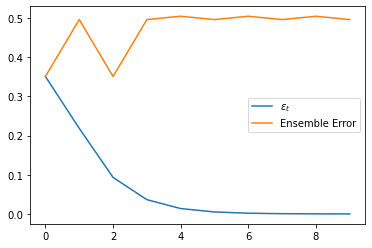

In [84]:
plt.plot(adaboost.wl_errors, label="$\epsilon_t$")
plt.plot(adaboost.ens_errors, label="Ensemble Error")
plt.legend()

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [88]:
class RandomLinearModel:
    def loss(self, y, y_, w):
        return np.sum(w[y != y_]) # la stessa loss di adaboost
        
    def fit(self,X,y,sample_weight=None):
        self.w = (np.random.rand(X.shape[1]) -0.5) * 2.0 # shape dà il numero di entry e il numero di feature
        y_ = self.predict(X)
        if self.loss(y, y_, sample_weight) > 0.5:
            self.w = -self.w
        return self
        
    def predict(self,X):
        return np.sign(np.matmul(X, self.w))

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [89]:
rs = RandomLinearModel()
a = AdaBoost(rs,10000)
a.fit(X_train,y_train)

step 100 epsilon_t:0.0007, error:0.5020
step 200 epsilon_t:0.0033, error:0.4950
step 300 epsilon_t:0.4763, error:0.4996
step 400 epsilon_t:0.0011, error:0.5069
step 500 epsilon_t:0.0002, error:0.5042
step 600 epsilon_t:0.0000, error:0.5002
step 700 epsilon_t:0.4153, error:0.5002
step 800 epsilon_t:0.0117, error:0.5042
step 900 epsilon_t:0.0405, error:0.5026
step 1000 epsilon_t:0.0000, error:0.4999
step 1100 epsilon_t:0.0000, error:0.5028
step 1200 epsilon_t:0.0818, error:0.4944
step 1300 epsilon_t:0.0181, error:0.4971
step 1400 epsilon_t:0.2310, error:0.5022
step 1500 epsilon_t:0.2066, error:0.5064
step 1600 epsilon_t:0.0089, error:0.5055
step 1700 epsilon_t:0.0000, error:0.5011
step 1800 epsilon_t:0.0375, error:0.5048
step 1900 epsilon_t:0.0006, error:0.5036
step 2000 epsilon_t:0.0000, error:0.5034
step 2100 epsilon_t:0.2260, error:0.4974
step 2200 epsilon_t:0.0000, error:0.5026
step 2300 epsilon_t:0.0000, error:0.5030
step 2400 epsilon_t:0.0000, error:0.5014
step 2500 epsilon_t:0.000

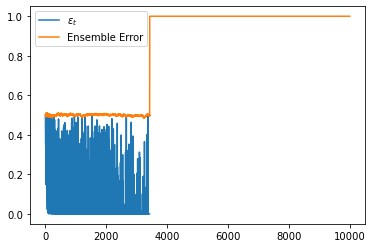

In [93]:
plt.plot(a.wl_errors, label="$\epsilon_t$")
plt.plot(a.ens_errors, label="Ensemble Error")
plt.legend()

In [94]:
accuracy_error = np.sum(y_train_ == y_train) / len(y_train)
test_error = np.sum(y_test_ == y_test) / len(y_test)

print("Error on\n\nAccuracy:\t{:.4f}\nTest:\t\t{:.4f}".format(accuracy_error, test_error))

Error on

Accuracy:	0.5042
Test:		0.5032
